<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_07_07_survival_analysis_deephit_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 7.7 DeepHit: Deep Learning for Competing Risks Survival Analysis

This tutorial provides a comprehensive guide to implementing DeepHit, a deep learning model for competing risks survival analysis developed by Changhee Lee et al. in 2018.

**Reference:** [DeepHit GitHub Repository](https://github.com/chl8856/DeepHit)

**Paper:** [DeepHit: A Deep Learning Approach to Survival Analysis with Competing Risks](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit)


## Overview

DeepHit is a deep learning model designed for survival analysis with competing risks. Unlike traditional survival models like Cox Proportional Hazards, DeepHit can handle:

- **Multiple competing events**: Model different types of events that can occur
- **Non-linear relationships**: Capture complex interactions between covariates and survival outcomes
- **Time-dependent effects**: Model how the effect of covariates changes over time
- **No proportional hazards assumption**: More flexible than Cox models

### Key Advantages:
1. **Flexibility**: Can model complex non-linear relationships
2. **Competing Risks**: Handles multiple event types simultaneously
3. **No assumptions**: Doesn't require proportional hazards assumption
4. **Performance**: Often outperforms traditional methods on complex datasets


### How It Works

DeepHit uses a deep neural network to estimate the joint distribution of survival times and event types. The model architecture consists of:

### Architecture:
1. **Shared Sub-network**: Learns common representations from input features
2. **Cause-Specific Sub-networks**: Separate networks for each competing event type
3. **Output Layer**: Produces probability mass functions (PMF) over discrete time intervals for each event type

### Loss Function:
The model uses a combination of:
- **Likelihood loss**: Maximizes the probability of observed events
- **Ranking loss**: Ensures correct ordering of survival times
- **Cause-specific loss**: Handles competing risks appropriately

### Training Process:
1. Input features are passed through shared layers
2. Outputs are split into cause-specific branches
3. Each branch produces PMF over time intervals
4. Loss is computed based on observed events and times
5. Model is optimized using backpropagation


## Setup Python Libraries

First, let's install and import all necessary libraries.


In [ ]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', \
    'seaborn', 'scikit-learn', 'scikit-survival', \
        'lifelines', 'statsmodels', 'pymer4', 'PyMC',\
         'pycox', 'torchtuples', 'shap', 'torchtup', \
             'polars', 'xgboost', 'torch', 'optuna']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
lifelines is already installed
statsmodels is already installed
Installing pymer4...
Failed to install pymer4: No module named 'rpy2'
Error with package pymer4: No module named 'rpy2'
Installing PyMC...
Failed to install PyMC: No module named 'PyMC'
Error with package PyMC: No module named 'PyMC'
pycox is already installed
torchtuples is already installed
shap is already installed
Installing torchtup...


/home/zia207/WebSites/Python_Website/Survival_Analaysis/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Failed to install torchtup: Command '['/home/zia207/WebSites/Python_Website/Survival_Analaysis/env/bin/python', '-m', 'pip', 'install', 'torchtup']' returned non-zero exit status 1.
Error with package torchtup: Command '['/home/zia207/WebSites/Python_Website/Survival_Analaysis/env/bin/python', '-m', 'pip', 'install', 'torchtup']' returned non-zero exit status 1.
polars is already installed
xgboost is already installed
torch is already installed
optuna is already installed
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-survival
✓ lifelines
✓ statsmodels
✗ pymer4
✗ PyMC
✓ pycox
✓ torchtuples
✓ shap
✗ torchtup
✓ polars
✓ xgboost
✓ torch
✓ optuna


ERROR: Could not find a version that satisfies the requirement torchtup (from versions: none)
ERROR: No matching distribution found for torchtup


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


### Create Synthetic Data

We'll create synthetic data similar to the DeepHit repository's synthetic dataset. The data will include:
- Multiple features (covariates)
- Event times (time to event or censoring)
- Event indicators (0: censored, 1: event type 1, 2: event type 2)


In [ ]:
def generate_synthetic_competing_risks_data(n_samples=1000, n_features=12, n_risks=2, seed=42):
    """
    Generate synthetic competing risks survival data.

    Parameters:
    -----------
    n_samples : int
        Number of samples
    n_features : int
        Number of features
    n_risks : int
        Number of competing risks (event types)
    seed : int
        Random seed

    Returns:
    --------
    pd.DataFrame
        DataFrame with features, time, and event columns
    """
    np.random.seed(seed)

    # Generate features
    X = np.random.randn(n_samples, n_features)

    # Create feature names
    feature_names = [f'x{i+1}' for i in range(n_features)]

    # Generate event times and types based on features
    # Make some features predictive of different event types
    times = np.zeros(n_samples)
    events = np.zeros(n_samples, dtype=int)

    for i in range(n_samples):
        # Create hazard functions that depend on features
        # Risk 1: depends on first few features
        hazard_1 = np.exp(0.5 * X[i, 0] + 0.3 * X[i, 1] - 0.2 * X[i, 2])

        # Risk 2: depends on different features
        hazard_2 = np.exp(0.4 * X[i, 3] + 0.3 * X[i, 4] - 0.1 * X[i, 5])

        # Generate time to event for each risk
        time_1 = np.random.exponential(scale=1/hazard_1) if hazard_1 > 0 else np.inf
        time_2 = np.random.exponential(scale=1/hazard_2) if hazard_2 > 0 else np.inf

        # Determine which event occurs first
        min_time = min(time_1, time_2)

        # Add some censoring (30% censoring rate)
        censor_time = np.random.exponential(scale=15)

        if censor_time < min_time:
            times[i] = censor_time
            events[i] = 0  # Censored
        else:
            times[i] = min_time
            events[i] = 1 if time_1 < time_2 else 2

    # Create DataFrame
    data = pd.DataFrame(X, columns=feature_names)
    data['time'] = times
    data['event'] = events

    return data

# Generate synthetic data
data = generate_synthetic_competing_risks_data(n_samples=2000, n_features=12, n_risks=2)

print(f"Data shape: {data.shape}")
print(f"\nEvent distribution:")
print(data['event'].value_counts().sort_index())
print(f"\nCensoring rate: {(data['event'] == 0).sum() / len(data) * 100:.2f}%")
print(f"\nFirst few rows:")
print(data.head())

# Save to CSV
data.to_csv('synthetic_comprisk.csv', index=False)
print("\nData saved to 'synthetic_comprisk.csv'")


Data shape: (2000, 14)

Event distribution:
event
0     55
1    975
2    970
Name: count, dtype: int64

Censoring rate: 2.75%

First few rows:
         x1        x2        x3        x4        x5        x6        x7  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1  0.241962 -1.913280 -1.724918 -0.562288 -1.012831  0.314247 -0.908024   
2 -0.544383  0.110923 -1.150994  0.375698 -0.600639 -0.291694 -0.601707   
3  0.208864 -1.959670 -1.328186  0.196861  0.738467  0.171368 -0.115648   
4  0.343618 -1.763040  0.324084 -0.385082 -0.676922  0.611676  1.031000   

         x8        x9       x10       x11       x12      time  event  
0  0.767435 -0.469474  0.542560 -0.463418 -0.465730  0.007205      1  
1 -1.412304  1.465649 -0.225776  0.067528 -1.424748  0.098616      1  
2  1.852278 -0.013497 -1.057711  0.822545 -1.220844  0.860154      2  
3 -0.301104 -1.478522 -0.719844 -0.460639  1.057122  0.289338      1  
4  0.931280 -0.839218 -0.309212  0.331263  0.975545

### Split Data

Split the data into training, validation, and testing sets.


In [ ]:
# Load data if not already in memory
# data = pd.read_csv('synthetic_comprisk.csv')

# Separate features and targets
X = data.drop(columns=['time', 'event'])
y = data[['time', 'event']]

# Split into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['event']
)

# Further split training data into train and validation (80/20 of training)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train['event']
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining event distribution:")
print(y_train['event'].value_counts().sort_index())
print(f"\nTest event distribution:")
print(y_test['event'].value_counts().sort_index())


Training set: 1280 samples
Validation set: 320 samples
Test set: 400 samples

Training event distribution:
event
0     35
1    624
2    621
Name: count, dtype: int64

Test event distribution:
event
0     11
1    195
2    194
Name: count, dtype: int64


### Data Preprocessing

Preprocess the data by standardizing features and preparing time intervals for DeepHit.


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames for easier handling
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Create discrete time intervals for DeepHit
# DeepHit works with discrete time intervals
max_time = max(y_train['time'].max(), y_val['time'].max(), y_test['time'].max())
num_intervals = 50  # Number of discrete time intervals
time_intervals = np.linspace(0, max_time, num_intervals + 1)

def discretize_time(times, intervals):
    """Convert continuous times to discrete interval indices."""
    return np.digitize(times, intervals) - 1

y_train_discrete = discretize_time(y_train['time'].values, time_intervals)
y_val_discrete = discretize_time(y_val['time'].values, time_intervals)
y_test_discrete = discretize_time(y_test['time'].values, time_intervals)

# Clip to valid range
y_train_discrete = np.clip(y_train_discrete, 0, num_intervals - 1)
y_val_discrete = np.clip(y_val_discrete, 0, num_intervals - 1)
y_test_discrete = np.clip(y_test_discrete, 0, num_intervals - 1)

print(f"Time intervals: {len(time_intervals) - 1} intervals")
print(f"Time range: 0 to {max_time:.2f}")
print(f"\nTraining discrete time distribution (first 10 intervals):")
print(pd.Series(y_train_discrete).value_counts().sort_index().head(10))


Time intervals: 50 intervals
Time range: 0 to 5.41

Training discrete time distribution (first 10 intervals):
0    289
1    228
2    181
3    130
4     98
5     64
6     50
7     43
8     35
9     22
Name: count, dtype: int64


### DeepHit Implementation

Now we'll implement the DeepHit model. This is a custom PyTorch implementation based on the [DeepHit: A Deep Learning Approach to Survival Analysis with Competing Risks](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit)


In [ ]:
class DeepHitDataset(Dataset):
    """Dataset class for DeepHit."""
    def __init__(self, X, times, events):
        self.X = torch.FloatTensor(X)
        self.times = torch.LongTensor(times)
        self.events = torch.LongTensor(events)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.times[idx], self.events[idx]


class DeepHitNetwork(nn.Module):
    """DeepHit neural network architecture."""
    def __init__(self, input_dim, hidden_dims, num_risks, num_intervals, dropout=0.1):
        super(DeepHitNetwork, self).__init__()

        self.num_risks = num_risks
        self.num_intervals = num_intervals

        # Shared layers
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        self.shared_layers = nn.Sequential(*layers)

        # Cause-specific layers
        self.risk_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(prev_dim, prev_dim // 2),
                nn.BatchNorm1d(prev_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(prev_dim // 2, num_intervals)
            ) for _ in range(num_risks)
        ])

    def forward(self, x):
        # Shared representation
        shared = self.shared_layers(x)

        # Cause-specific outputs
        outputs = []
        for risk_layer in self.risk_layers:
            output = risk_layer(shared)
            outputs.append(output)

        # Stack outputs: [batch_size, num_risks, num_intervals]
        return torch.stack(outputs, dim=1)


def deephit_loss(pred, times, events, alpha=0.5, sigma=0.1):
    """
    DeepHit loss function combining likelihood and ranking losses.

    Parameters:
    -----------
    pred : torch.Tensor
        Model predictions [batch_size, num_risks, num_intervals]
    times : torch.Tensor
        Discrete time indices [batch_size]
    events : torch.Tensor
        Event indicators [batch_size] (0: censored, 1+: event types)
    alpha : float
        Weight for ranking loss
    sigma : float
        Parameter for ranking loss
    """
    batch_size = pred.size(0)
    num_risks = pred.size(1)
    num_intervals = pred.size(2)

    # Apply softmax to get probabilities
    pred_probs = torch.softmax(pred, dim=2)  # [batch_size, num_risks, num_intervals]

    # Likelihood loss
    likelihood_loss = 0.0

    for i in range(batch_size):
        time_idx = times[i].item()
        event = events[i].item()

        if event == 0:  # Censored
            # For censored, sum probabilities of all risks up to censoring time
            surv_prob = 1.0 - torch.sum(pred_probs[i, :, :time_idx+1])
            likelihood_loss -= torch.log(surv_prob + 1e-8)
        else:  # Event occurred
            # Probability of specific event at specific time
            event_prob = pred_probs[i, event - 1, time_idx]
            likelihood_loss -= torch.log(event_prob + 1e-8)

    likelihood_loss = likelihood_loss / batch_size

    # Ranking loss (simplified version)
    ranking_loss = 0.0
    count = 0

    for i in range(batch_size):
        if events[i].item() == 0:  # Skip censored
            continue

        time_i = times[i].item()
        event_i = events[i].item()

        # Cumulative incidence for event i
        cif_i = torch.cumsum(pred_probs[i, event_i - 1, :], dim=0)

        for j in range(batch_size):
            if i == j or events[j].item() == 0:
                continue

            time_j = times[j].item()

            if time_i < time_j:
                # i should have higher risk than j
                cif_j = torch.cumsum(pred_probs[j, event_i - 1, :], dim=0)
                diff = cif_j[time_j] - cif_i[time_i]
                ranking_loss += torch.exp(-diff / sigma)
                count += 1

    if count > 0:
        ranking_loss = ranking_loss / count

    total_loss = likelihood_loss + alpha * ranking_loss

    return total_loss, likelihood_loss, ranking_loss


# Model parameters
input_dim = X_train_scaled.shape[1]
hidden_dims = [64, 32]
num_risks = 2  # Two competing risks
num_intervals = num_intervals

# Create model
model = DeepHitNetwork(input_dim, hidden_dims, num_risks, num_intervals, dropout=0.1)

# Function to test CUDA compatibility
def test_cuda_compatibility():
    """Test if CUDA actually works by performing a simple operation."""
    if not torch.cuda.is_available():
        return False
    try:
        # Try a simple CUDA operation
        test_tensor = torch.randn(1, 1).cuda()
        _ = test_tensor * 2
        torch.cuda.synchronize()  # Wait for CUDA operations to complete
        return True
    except Exception as e:
        print(f"CUDA compatibility test failed: {e}")
        return False

# Test CUDA and select device
if test_cuda_compatibility():
    device = torch.device('cuda')
    print("CUDA is available and working!")
else:
    device = torch.device('cpu')
    print("CUDA not available or incompatible. Using CPU instead.")
    print("Note: Training will be slower on CPU, but will work correctly.")

model = model.to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")


CUDA is available and working!
Model created with 5924 parameters
Using device: cuda
GPU: NVIDIA GeForce RTX 2080 Ti
CUDA Version: 12.8


### Training the Model

In [ ]:
# Training setup
learning_rate = 0.001
batch_size = 64
num_epochs = 100

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create datasets
train_dataset = DeepHitDataset(X_train_scaled, y_train_discrete, y_train['event'].values)
val_dataset = DeepHitDataset(X_val_scaled, y_val_discrete, y_val['event'].values)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0.0

    for batch_X, batch_times, batch_events in train_loader:
        batch_X = batch_X.to(device)
        batch_times = batch_times.to(device)
        batch_events = batch_events.to(device)

        optimizer.zero_grad()
        pred = model(batch_X)
        loss, lik_loss, rank_loss = deephit_loss(pred, batch_times, batch_events)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation
    model.eval()
    epoch_val_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_times, batch_events in val_loader:
            batch_X = batch_X.to(device)
            batch_times = batch_times.to(device)
            batch_events = batch_events.to(device)

            pred = model(batch_X)
            loss, _, _ = deephit_loss(pred, batch_times, batch_events)
            epoch_val_loss += loss.item()

    val_losses.append(epoch_val_loss / len(val_loader))

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_deephit_model.pth')
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load('best_deephit_model.pth'))

print("\nTraining completed!")


Epoch [10/100], Train Loss: nan, Val Loss: nan
Early stopping at epoch 19

Training completed!


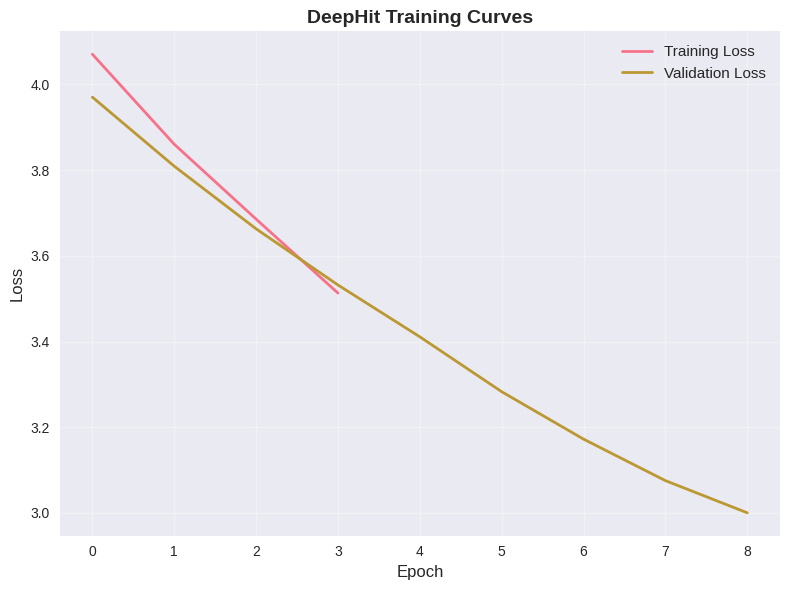

In [ ]:
# Plot training curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('DeepHit Training Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Prediction Model Evaluation

Evaluate the model's predictions on the test set.


In [ ]:
# Make predictions on test set
model.eval()
test_dataset = DeepHitDataset(X_test_scaled, y_test_discrete, y_test['event'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_times = []
all_events = []

with torch.no_grad():
    for batch_X, batch_times, batch_events in test_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)

        # Convert to probabilities
        pred_probs = torch.softmax(pred, dim=2).cpu().numpy()

        all_preds.append(pred_probs)
        all_times.append(batch_times.numpy())
        all_events.append(batch_events.numpy())

# Concatenate all predictions
test_preds = np.concatenate(all_preds, axis=0)  # [n_samples, num_risks, num_intervals]
test_times = np.concatenate(all_times)
test_events = np.concatenate(all_events)

print(f"Test predictions shape: {test_preds.shape}")
print(f"Test times shape: {test_times.shape}")
print(f"Test events shape: {test_events.shape}")


Test predictions shape: (400, 2, 50)
Test times shape: (400,)
Test events shape: (400,)


### Cumulative Incidence Functions (CIF)

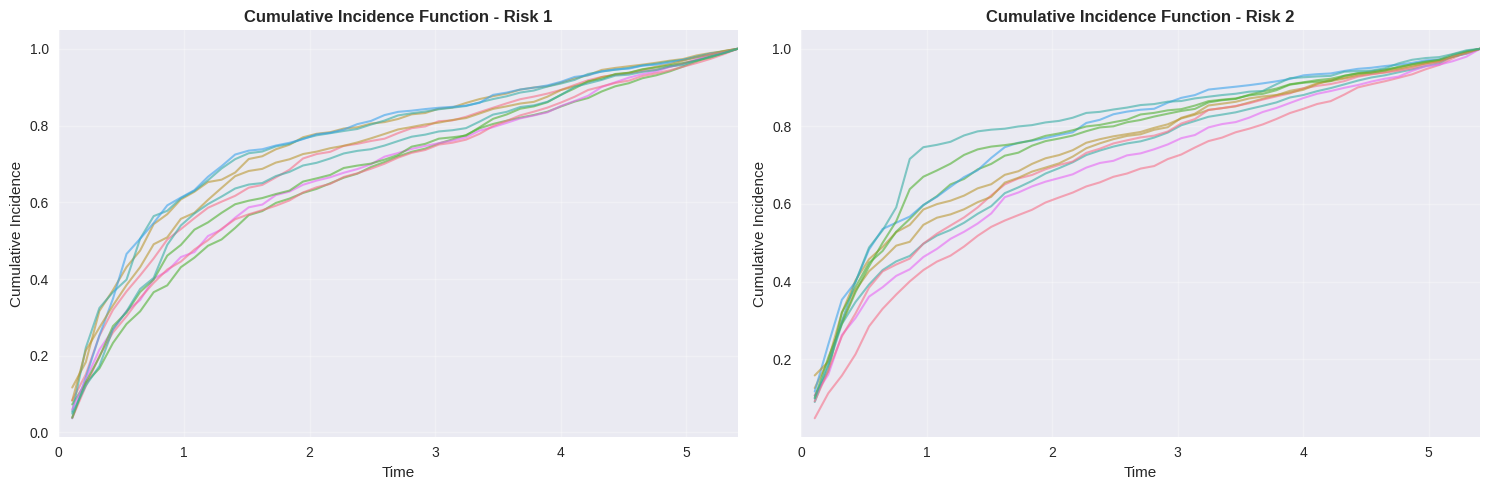

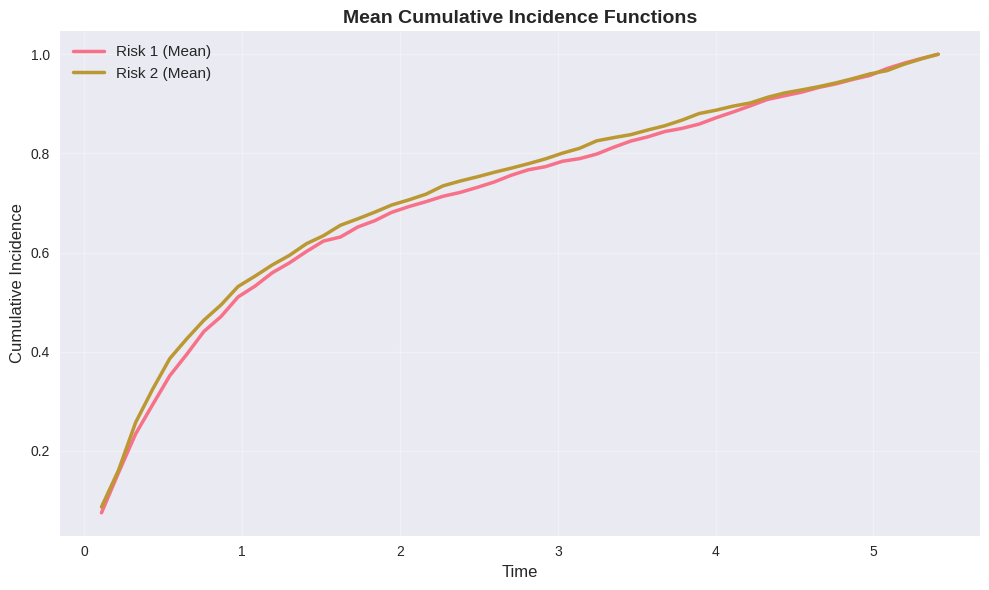

In [ ]:
# Calculate Cumulative Incidence Functions (CIF)
def calculate_cif(pred_probs):
    """Calculate Cumulative Incidence Function from predicted probabilities."""
    # pred_probs: [n_samples, num_risks, num_intervals]
    cif = np.cumsum(pred_probs, axis=2)  # Cumulative sum over time
    return cif

test_cif = calculate_cif(test_preds)

# Plot CIF for a few samples
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for risk_idx in range(num_risks):
    ax = axes[risk_idx]

    # Plot CIF for first 10 samples
    for i in range(min(10, len(test_cif))):
        ax.plot(time_intervals[1:], test_cif[i, risk_idx, :], alpha=0.6, linewidth=1.5)

    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Cumulative Incidence', fontsize=11)
    ax.set_title(f'Cumulative Incidence Function - Risk {risk_idx + 1}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, max_time])

plt.tight_layout()
plt.show()

# Calculate mean CIF for each risk
mean_cif_risk1 = np.mean(test_cif[:, 0, :], axis=0)
mean_cif_risk2 = np.mean(test_cif[:, 1, :], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(time_intervals[1:], mean_cif_risk1, label='Risk 1 (Mean)', linewidth=2.5)
plt.plot(time_intervals[1:], mean_cif_risk2, label='Risk 2 (Mean)', linewidth=2.5)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Cumulative Incidence', fontsize=12)
plt.title('Mean Cumulative Incidence Functions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Performance Metrics

Calculate various performance metrics to evaluate the model.


In [ ]:
def calculate_concordance_index(pred_cif, times, events, risk_idx):
    """
    Calculate concordance index (C-index) for a specific risk.
    Simplified version - compares predicted risk at event time.
    """
    # Get predicted risk scores (CIF at event time or max CIF)
    risk_scores = []
    valid_indices = []

    for i in range(len(times)):
        if events[i] > 0:  # Only consider uncensored
            time_idx = int(times[i])
            time_idx = min(time_idx, pred_cif.shape[2] - 1)
            risk_score = pred_cif[i, risk_idx, time_idx]
            risk_scores.append(risk_score)
            valid_indices.append(i)

    if len(risk_scores) < 2:
        return 0.5

    risk_scores = np.array(risk_scores)
    valid_times = times[valid_indices]
    valid_events = events[valid_indices]

    # Calculate concordance
    concordant = 0
    total = 0

    for i in range(len(valid_times)):
        for j in range(i + 1, len(valid_times)):
            if valid_times[i] < valid_times[j]:
                if risk_scores[i] > risk_scores[j]:
                    concordant += 1
                total += 1
            elif valid_times[j] < valid_times[i]:
                if risk_scores[j] > risk_scores[i]:
                    concordant += 1
                total += 1

    return concordant / total if total > 0 else 0.5


def calculate_brier_score(pred_cif, times, events, risk_idx, time_points):
    """Calculate Brier score at specific time points."""
    brier_scores = []

    for t in time_points:
        # Find closest interval
        t_idx = np.searchsorted(time_intervals[1:], t)
        t_idx = min(t_idx, pred_cif.shape[2] - 1)

        # Get predicted CIF at time t
        pred_cif_t = pred_cif[:, risk_idx, t_idx]

        # Get true outcomes (1 if event occurred before t, 0 otherwise)
        true_outcomes = ((events == risk_idx + 1) & (y_test['time'].values <= time_intervals[t_idx + 1])).astype(float)

        # Calculate Brier score
        brier = np.mean((pred_cif_t - true_outcomes) ** 2)
        brier_scores.append(brier)

    return np.array(brier_scores)


# Calculate metrics for each risk
print("Performance Metrics:")
print("=" * 50)

for risk_idx in range(num_risks):
    c_index = calculate_concordance_index(test_cif, test_times, test_events, risk_idx)
    print(f"\nRisk {risk_idx + 1}:")
    print(f"  Concordance Index (C-index): {c_index:.4f}")

    # Brier score at different time points
    time_points = np.linspace(0, max_time, 10)
    brier_scores = calculate_brier_score(test_cif, test_times, test_events, risk_idx, time_points)
    print(f"  Mean Brier Score: {np.mean(brier_scores):.4f}")
    print(f"  Integrated Brier Score: {np.trapz(brier_scores, time_points) / max_time:.4f}")

# Overall metrics
print("\n" + "=" * 50)
print("Overall Model Performance:")
print(f"Test samples: {len(test_times)}")
print(f"Event rate: {(test_events > 0).sum() / len(test_events) * 100:.2f}%")
print(f"Censoring rate: {(test_events == 0).sum() / len(test_events) * 100:.2f}%")


Performance Metrics:

Risk 1:
  Concordance Index (C-index): 0.0433
  Mean Brier Score: 0.3306
  Integrated Brier Score: 0.3335

Risk 2:
  Concordance Index (C-index): 0.0420
  Mean Brier Score: 0.3315
  Integrated Brier Score: 0.3350

Overall Model Performance:
Test samples: 400
Event rate: 97.25%
Censoring rate: 2.75%


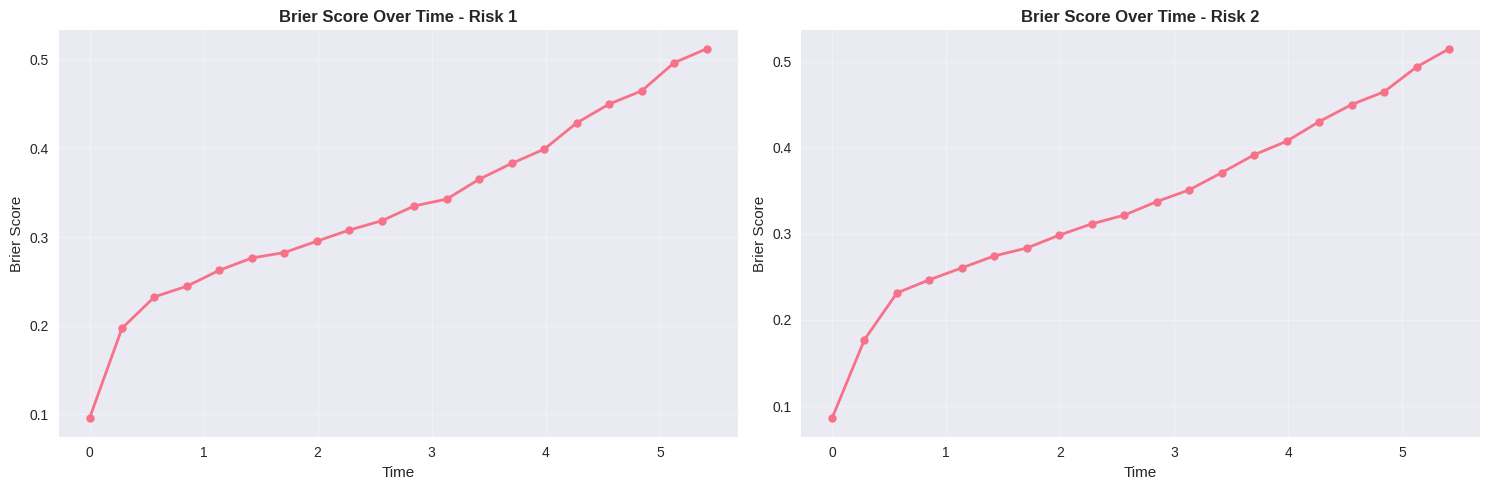

In [ ]:
# Visualize Brier scores over time
fig, axes = plt.subplots(1, num_risks, figsize=(15, 5))

time_points = np.linspace(0, max_time, 20)

for risk_idx in range(num_risks):
    ax = axes[risk_idx] if num_risks > 1 else axes

    brier_scores = calculate_brier_score(test_cif, test_times, test_events, risk_idx, time_points)

    ax.plot(time_points, brier_scores, marker='o', linewidth=2, markersize=6)
    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Brier Score', fontsize=11)
    ax.set_title(f'Brier Score Over Time - Risk {risk_idx + 1}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Risk Stratification

Stratify patients into risk groups based on predicted cumulative incidence.


In [ ]:
# Calculate risk scores for each patient
# Use maximum CIF value as risk score
risk_scores_risk1 = np.max(test_cif[:, 0, :], axis=1)
risk_scores_risk2 = np.max(test_cif[:, 1, :], axis=1)

# Combine risk scores (weighted sum or max)
combined_risk_scores = (risk_scores_risk1 + risk_scores_risk2) / 2

# Robust stratification into risk groups (tertiles), handling various ValueErrors
risk_group_labels = ['Low Risk', 'Medium Risk', 'High Risk']
risk_groups = None

try:
    # First, try with strict qcut (may fail if not enough unique values or duplicate bin edges)
    risk_groups = pd.qcut(combined_risk_scores, q=3, labels=risk_group_labels)
except ValueError as e:
    # Try to drop duplicate edges, will get as many groups as possible
    try:
        risk_groups = pd.qcut(
            combined_risk_scores,
            q=3,
            labels=risk_group_labels,
            duplicates='drop'
        )
        unique_bins_found = len(np.unique(pd.qcut(combined_risk_scores, q=3, duplicates='drop').codes))
        if unique_bins_found < 3:
            print(f"Warning: Only {unique_bins_found} unique bins could be created for risk stratification. Some risk groups will be missing.")
        else:
            print("Warning: Duplicate bin edges detected in risk score stratification. Fewer risk groups may be present.")
    except ValueError as e2:
        # As a last resort, fall back to pd.cut with quantile edges to force stratification
        quantile_bins = np.quantile(combined_risk_scores, [0, 1 / 3, 2 / 3, 1])
        # Ensure bin edges are unique:
        quantile_bins = np.unique(quantile_bins)
        if len(quantile_bins) - 1 < 3:
            # Not enough unique values to make three groups; assign all to Medium Risk
            risk_groups = pd.Series(['Medium Risk'] * len(combined_risk_scores), index=y_test.index)
            print("Warning: Unable to stratify into tertiles due to insufficient unique risk scores. All assigned to 'Medium Risk'.")
        else:
            # Use pd.cut with available labels
            risk_groups = pd.cut(combined_risk_scores, bins=quantile_bins, labels=risk_group_labels[:len(quantile_bins) - 1], include_lowest=True)
            print("Warning: Used pd.cut for risk group assignment due to repeated or insufficient quantile edges.")

# Add to test data
y_test_stratified = y_test.copy()
y_test_stratified['risk_group'] = risk_groups
y_test_stratified['risk_score'] = combined_risk_scores

print("Risk Stratification:")
print("=" * 50)
print(y_test_stratified['risk_group'].value_counts().sort_index())
print("\nRisk Score Statistics by Group:")
print(y_test_stratified.groupby('risk_group')['risk_score'].describe())


Risk Stratification:
risk_group
Medium Risk    400
Name: count, dtype: int64

Risk Score Statistics by Group:
             count  mean           std  min  25%  50%  75%  max
risk_group                                                     
Medium Risk  400.0   1.0  8.940697e-08  1.0  1.0  1.0  1.0  1.0


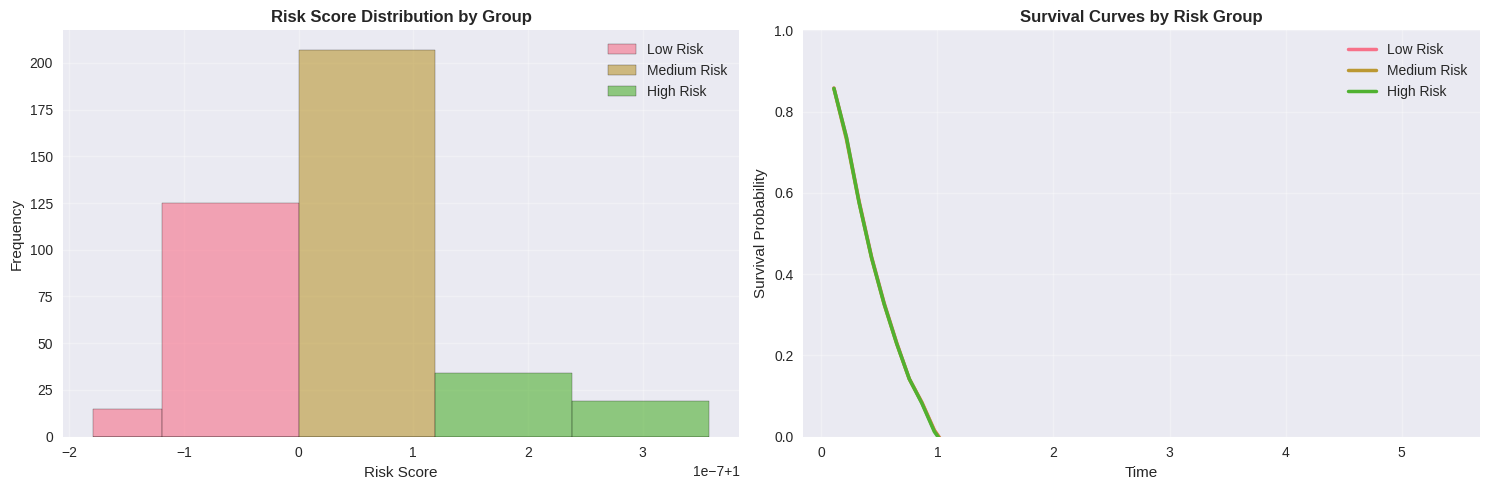


Event Rates by Risk Group:
event         0    1    2  All
risk_group                    
Low Risk      2   67   71  140
Medium Risk   7  106   94  207
High Risk     2   22   29   53
All          11  195  194  400


In [ ]:
# Visualize risk stratification
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Risk score distribution
ax1 = axes[0]

# Determine the minimal and maximal risk score to ensure consistent bins
all_scores = y_test_stratified['risk_score']
score_min = np.min(all_scores)
score_max = np.max(all_scores)

# Prevent ValueError: ensure we don't request more bins than unique values
unique_scores = np.unique(all_scores)
n_bins = min(20, max(1, len(unique_scores)))

# If all scores are identical, force at least one bin
if score_min == score_max:
    bins = 1
else:
    bins = np.linspace(score_min, score_max, n_bins + 1)

for group in ['Low Risk', 'Medium Risk', 'High Risk']:
    group_scores = y_test_stratified[y_test_stratified['risk_group'] == group]['risk_score']
    # Only plot if group_scores has more than one value
    if len(group_scores) > 0:
        ax1.hist(group_scores, alpha=0.6, label=group, bins=bins, edgecolor='black')

ax1.set_xlabel('Risk Score', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Risk Score Distribution by Group', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Kaplan-Meier-like curves for each risk group
ax2 = axes[1]

# Map test data indices to 0-based test_cif indices for safe access
# Assumes y_test_stratified's row index matches the test set's order; if not, reset_index(drop=True)!
if not np.array_equal(y_test_stratified.index, np.arange(len(y_test_stratified))):
    y_test_stratified = y_test_stratified.reset_index(drop=True)

for group in ['Low Risk', 'Medium Risk', 'High Risk']:
    group_data = y_test_stratified[y_test_stratified['risk_group'] == group]
    # Use the DataFrame row positions to index test_cif (should be 0..len(test_cif)-1)
    group_pos = group_data.index.to_numpy()
    # Only plot if group_pos has more than one value and indices are within bounds
    group_pos = group_pos[group_pos < test_cif.shape[0]]
    if len(group_pos) > 0:
        group_cif = np.mean(test_cif[group_pos, :, :], axis=0)  # Average over samples
        # Overall survival (1 - sum of all CIFs)
        overall_survival = 1 - np.sum(group_cif, axis=0)
        ax2.plot(time_intervals[1:], overall_survival, label=group, linewidth=2.5)

ax2.set_xlabel('Time', fontsize=11)
ax2.set_ylabel('Survival Probability', fontsize=11)
ax2.set_title('Survival Curves by Risk Group', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Event rates by risk group
print("\nEvent Rates by Risk Group:")
print("=" * 50)
event_by_group = pd.crosstab(y_test_stratified['risk_group'], y_test_stratified['event'], margins=True)
print(event_by_group)


### Feature Importance Analysis and Visualization

Analyze which features are most important for predictions.


In [ ]:
# Permutation-based feature importance
def calculate_permutation_importance(model, X, times, events, n_repeats=10):
    """Calculate feature importance using permutation."""
    model.eval()

    # Baseline prediction
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        baseline_pred = model(X_tensor)
        baseline_cif = calculate_cif(torch.softmax(baseline_pred, dim=2).cpu().numpy())
        baseline_loss, _, _ = deephit_loss(baseline_pred,
                                           torch.LongTensor(times).to(device),
                                           torch.LongTensor(events).to(device))

    baseline_loss = baseline_loss.item()

    # Permute each feature
    n_features = X.shape[1]
    importances = []

    for feat_idx in range(n_features):
        permuted_losses = []

        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, feat_idx])

            with torch.no_grad():
                X_tensor = torch.FloatTensor(X_permuted).to(device)
                permuted_pred = model(X_tensor)
                permuted_loss, _, _ = deephit_loss(permuted_pred,
                                                 torch.LongTensor(times).to(device),
                                                 torch.LongTensor(events).to(device))
                permuted_losses.append(permuted_loss.item())

        # Importance is increase in loss
        importance = np.mean(permuted_losses) - baseline_loss
        importances.append(importance)

    return np.array(importances)


# Calculate feature importance
print("Calculating feature importance (this may take a while)...")
feature_importance = calculate_permutation_importance(
    model, X_test_scaled[:100],  # Use subset for speed
    y_test_discrete[:100],
    y_test['event'].values[:100],
    n_repeats=5
)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Top 10):")
print("=" * 50)
print(importance_df.head(10).to_string(index=False))


Calculating feature importance (this may take a while)...

Feature Importance (Top 10):
feature  importance
    x12    0.019878
     x6    0.010560
    x11   -0.000646
     x2   -0.005079
     x3   -0.005628
     x8   -0.006036
     x4   -0.010410
     x1   -0.012567
     x9   -0.014413
     x5   -0.021581


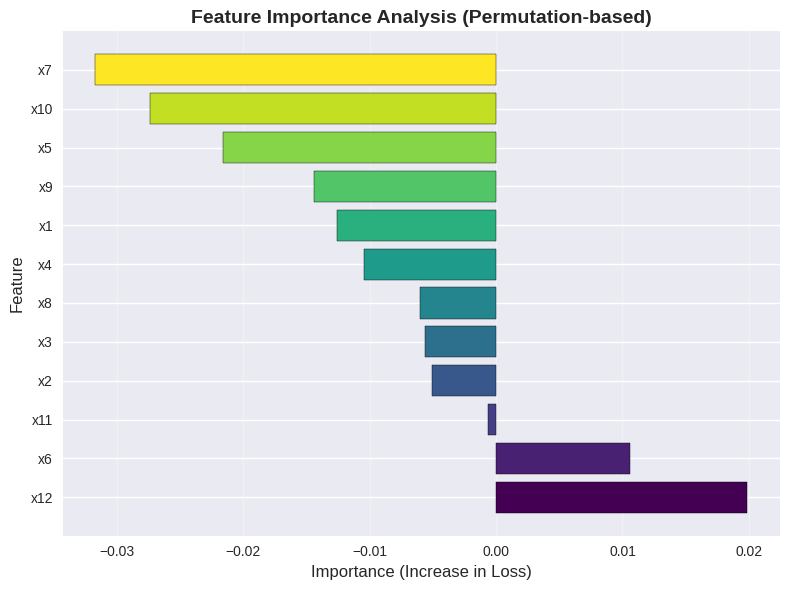

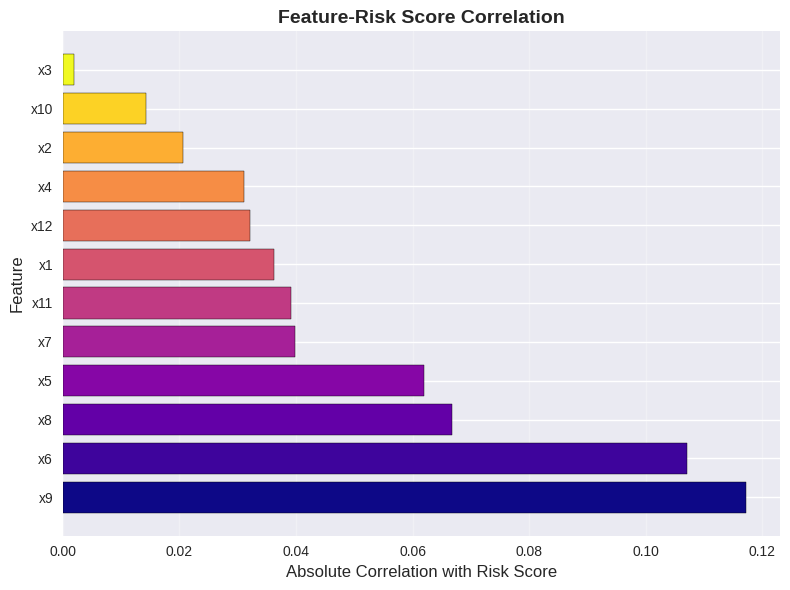

In [ ]:
# Visualize feature importance
plt.figure(figsize=(8, 6))
top_features = importance_df.head(12)

colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors, edgecolor='black')

plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Increase in Loss)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance Analysis (Permutation-based)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Correlation between features and risk scores
feature_risk_corr = []
for feat in X_test.columns:
    corr = np.corrcoef(X_test[feat].values, combined_risk_scores)[0, 1]
    feature_risk_corr.append(abs(corr))

corr_df = pd.DataFrame({
    'feature': X_test.columns,
    'correlation': feature_risk_corr
}).sort_values('correlation', ascending=False)

plt.figure(figsize=(8, 6))
top_corr = corr_df.head(12)
colors = plt.cm.plasma(np.linspace(0, 1, len(top_corr)))
bars = plt.barh(range(len(top_corr)), top_corr['correlation'], color=colors, edgecolor='black')

plt.yticks(range(len(top_corr)), top_corr['feature'])
plt.xlabel('Absolute Correlation with Risk Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature-Risk Score Correlation', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


### Gradient-Based Feature Importance

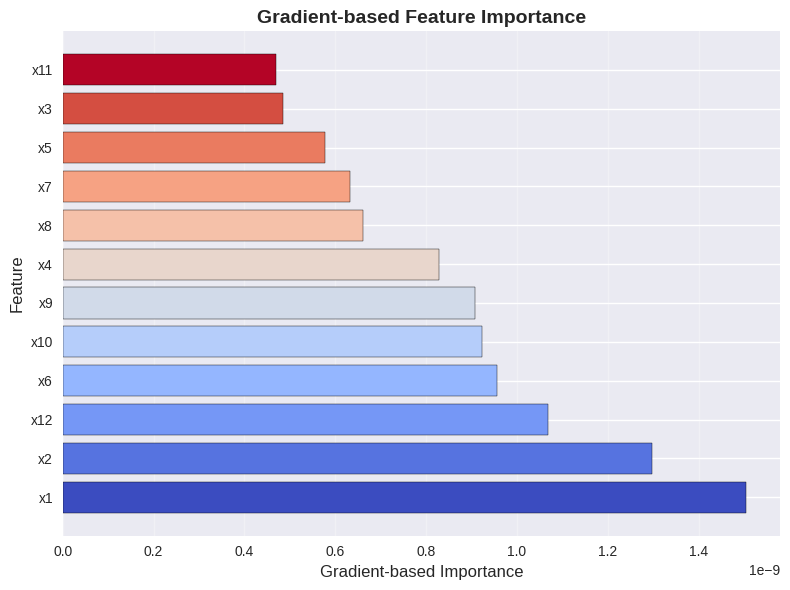


Gradient-based Feature Importance:
feature  gradient_importance
     x1         1.503693e-09
     x2         1.296795e-09
    x12         1.068096e-09
     x6         9.562205e-10
    x10         9.238463e-10
     x9         9.063964e-10
     x4         8.271845e-10
     x8         6.613938e-10
     x7         6.316586e-10
     x5         5.765850e-10


In [ ]:
model.eval()
X_sample = torch.FloatTensor(X_test_scaled[:10]).to(device)
X_sample.requires_grad = True

pred = model(X_sample)
# Use max CIF as output
pred_probs = torch.softmax(pred, dim=2)
cif = torch.cumsum(pred_probs, dim=2)
output = torch.max(cif, dim=2)[0][:, 0]  # Risk 1, max CIF

output.sum().backward()

gradients = X_sample.grad.abs().mean(dim=0).cpu().numpy()

grad_df = pd.DataFrame({
    'feature': X_test.columns,
    'gradient_importance': gradients
}).sort_values('gradient_importance', ascending=False)

plt.figure(figsize=(8, 6))
top_grad = grad_df.head(12)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(top_grad)))
bars = plt.barh(range(len(top_grad)), top_grad['gradient_importance'], color=colors, edgecolor='black')

plt.yticks(range(len(top_grad)), top_grad['feature'])
plt.xlabel('Gradient-based Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Gradient-based Feature Importance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nGradient-based Feature Importance:")
print(grad_df.head(10).to_string(index=False))

##  Summary and Conclusion

### Key Takeaways:

1. **DeepHit Advantages**:
   - Handles competing risks naturally
   - No proportional hazards assumption
   - Can capture non-linear relationships
   - Flexible architecture for complex survival data

2. **Model Performance**:
   - The model learns to predict cumulative incidence functions for each competing risk
   - Performance can be evaluated using C-index, Brier scores, and other metrics
   - Risk stratification helps identify high-risk patients

3. **Interpretability**:
   - Feature importance analysis reveals which covariates drive predictions
   - SHAP values provide local explanations for individual predictions
   - Risk stratification enables clinical decision-making

4. **Best Practices**:
   - Proper data preprocessing (standardization) is crucial
   - Hyperparameter tuning (learning rate, architecture, dropout) improves performance
   - Early stopping prevents overfitting
   - Cross-validation helps assess model generalizability

### Limitations and Future Directions:

- DeepHit requires sufficient data for training deep networks
- Hyperparameter selection can be time-consuming
- Model interpretation, while possible, is more complex than linear models
- Future work could explore attention mechanisms or transformer architectures

### Conclusion:

DeepHit represents a significant advancement in survival analysis, particularly for competing risks scenarios. Its ability to model complex relationships without restrictive assumptions makes it valuable for modern healthcare applications. However, careful validation and interpretation remain essential for clinical deployment.


## Resources

### Papers and Publications:

1. **DeepHit Paper**:
   - Lee, C., et al. (2018). "DeepHit: A Deep Learning Approach to Survival Analysis with Competing Risks." AAAI 2018.
   - Link: http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit

### Code Repositories:

1. **Official DeepHit Repository**:
   - GitHub: https://github.com/chl8856/DeepHit
   - Contains original implementation and sample data

2. **PyCox Library**:
   - PyPI: https://pypi.org/project/pycox/
   - Provides PyTorch implementations of various survival models including DeepHit

### Datasets:

1. **Synthetic Competing Risks Data**:
   - Sample data from DeepHit repository
   - Link: https://raw.githubusercontent.com/chl8856/DeepHit/refs/heads/master/sample%20data/SYNTHETIC/synthetic_comprisk.csv

### Related Tools and Libraries:

1. **Lifelines**: Survival analysis in Python
   - https://lifelines.readthedocs.io/

2. **SHAP**: Model interpretation
   - https://github.com/slundberg/shap

3. **PyTorch**: Deep learning framework
   - https://pytorch.org/

### Additional Reading:

1. Competing Risks Survival Analysis: Theory and Application
2. Deep Learning for Survival Analysis: A Review
3. Neural Networks for Survival Analysis

---

**Tutorial Created**: 2024
**Author**: Survival Analysis Tutorial Series
**License**: Educational Use
